In [28]:
import os
import re 
import pandas as pd
import seaborn as sns 

pointMiniGames = "Sammelwahn, Schießstand, Walls, Mini Survivalgames, Mini Skywars, Lasertag, Minengefecht, Einer im Köcher, Paintball, Spleef, Buntes Chaos, Reihenfolge, Duelle" 
timeMiniGames = "Wettrennen, Jump and Run, Pferderennen, Drachenflucht, Replika, Blockhüpfer, Todeswürfel, Freier Fall, Elytrarennen, Waffenfolge, Minenfeld, Kletter-König, Ampelrennen, Hoch hinaus"

miniGameList = ["1-Sammelwahn",
        "2-Schießstand",
        "3-Wettrennen",
        "4-Pferderennen",
        "5-Drachenflucht",
        "6-Jump and Run",
        "7-Hoch Hinaus",
        "8-Blockhüpfer",
        "9-Todeswürfel",
        "10-Freier Fall",
        "11-Elytrarennen",
        "12-Waffenfolge",
        "13-Minenfeld",
        "14-Kletterkönig",
        "15-Ampelrennen",
        "16-Replika",
        "17-Walls",
        "18-Mini SG",
        "19-Mini SW",
        "20-Lasertag",
        "21-Minengefecht",
        "22-OITC",
        "23-Paintball",
        "24-Spleef",
        "25-Buntes Chaos",
        "26-Reihenfolge",
        "27-Duelle"]

def getPlayerPaths():
    file_list = os.listdir('in-new')
    return file_list

def read_file(file):
    with open('in-new/'+file, 'r') as f:
        data = f.read().replace('TooltipEvent, ', '')
    return data

def getRecordData(playerPath, minigame):
    data = read_file(playerPath).split('\n')
    for line in data: 
        if minigame in line: 
            minigameData = line
            minigameData = minigameData.replace(minigame, '').strip()
            return minigameData  # return the data instead of printing it

def create_dataframe(input_string, minigame):

    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(?:(\d+)\s*min\s*)?(?:(\d+)\s*s\s*)?(\d+)\s*ms'

    # Find all matches in the input string
    try: matches = re.findall(pattern, input_string)
    except: matches = None

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    if matches: 
        for match in matches:
            map_name = match[0]
            minutes = int(match[1] or 0)
            seconds = int(match[2] or 0) + int(match[3]) / 1000
            time_seconds = minutes * 60 + seconds
            data[map_name] = time_seconds
    else: return pd.DataFrame()

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])


    return df

def createPointDataframe(input_string, minigame):
    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(\d+)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    for match in matches:
        map_name = match[0]
        time_value = int(match[1])
        data[map_name] = time_value

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])
    return df.fillna(0)


paths = getPlayerPaths()

def getRecordsDataframe(minigame='Wettrennen', save=False, log=False, html=False):
    outDf = pd.DataFrame()

    if log:
        print(f'processing {minigame}...')

    if minigame in pointMiniGames: 
        pass
    elif minigame in timeMiniGames:
        pass
    else: 
        ValueError('Not a valid minigame name')

    for i in paths:
        if minigame in timeMiniGames:
            df = create_dataframe(getRecordData(playerPath=i, minigame=minigame), minigame)
        if minigame in pointMiniGames:
            try: 
                df = createPointDataframe(getRecordData(playerPath=i, minigame=minigame), minigame)
                df.fillna(0, inplace=True)
            except: 
                continue

        if df is not None:  
            df.index = [i.replace('.txt', '')]
            outDf = pd.concat([outDf, df])

    if ("Replika" in minigame): 

        replikaDf = outDf 
        replikaDf.fillna(25, inplace=True) # assigning a value to a never-played-before pattern, 17 perturbs worse player order and alt account stats lol, 27 is probably too much, difficult to choose an appropriate value here
        row_sums = replikaDf.sum(axis=1)
        
        # Append the sum as a new column
        replikaDf['Sum'] = row_sums

        # Re-indexing
        replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)
    
        # Move 'Sum' column to the first position
        cols = replikaDf.columns.tolist()
        cols = ['Sum'] + [col for col in cols if col != 'Sum']
        replikaDf = replikaDf[cols]

        # Removing player data with too many NaNs (players that haven't played most of the patterns)
        # replikaDf = replikaDf.drop(columns=["Ritokii", "Feinberg", "Sebi1801"])

        outDf = replikaDf

    outPath = 'out/' + minigame + '.json'

    if save: 
        if "Replika" in minigame: 
            json_df = outDf.iloc[:, 1:]
            json_df.T.to_json(outPath)
        
        else: outDf.T.to_json(outPath) 


    if html: 
        log = False 
        html_table = ""
        if ("Drache" in minigame) or ("Mini" in minigame) or ("Köcher" in minigame) or ("Lasertag" in minigame) or ("Minengef" in minigame) or ("Paint" in minigame) or ("Reihenf" in minigame) or ("Sammel" in minigame) or ("Schießs" in minigame) or ("Spleef" in minigame) or ("Walls" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('<td>NaN</td>', '<td>0</td>').replace('.0</td>', '</td>').replace('Tötungen Asia', 'Asia').replace('Tötungen', '').replace('Punkte', '')
        elif ("Pferde" in minigame):
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9', '>09').replace('>8', '>08').replace('>7', '>07').replace('>6', '>06').replace('>5', '>05').replace('>4', '>04').replace('s Arena', "Wario's Arena").replace('>Cheep B', ">Cheep Cheep B")
        elif ("Replika" in minigame): 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('>9.', '>09.').replace('>8.', '>08.').replace('>7.', '>07.').replace('>6.', '>06.').replace('>5.', '>05.').replace('>4.', '>04.').replace('>3.', '>03.').replace('>ms ','>').replace('>30.000','>None')
        else: 
            html_table = (outDf.to_html()).replace('\n', '').replace('<table border="1" class="dataframe">', '').replace('Punkte', '').replace('Runden', '').replace('Blossom', 'Cherry Blossom')
        
        print(html_table)

    if log: 
        print(f'{minigame} processed and saved to {outPath}')

    if html == False: 
        return outDf


# HTML assembly #

frontWrapperList = []
x = 0
endWrapper = "</table> </div>"

for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
    x = x + 1
    strX = str(x)
    frontWrapperList.append('<!-- Table: ' + i + ' --> <div id="table' + strX + '" style="display:none;"> <table id="dataframe' + strX + '" class="display nowrap">')

print('<div class="table-container">')
x = 0
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')):
    print(frontWrapperList[x])
    getRecordsDataframe(minigame=i, save=True, log=False, html=True)
    print(endWrapper)
    x = x + 1
print('</div>')

<div class="table-container">
<!-- Table: Ampelrennen --> <div id="table1" style="display:none;"> <table id="dataframe1" class="display nowrap">
  <thead>    <tr style="text-align: right;">      <th></th>      <th>Castle</th>      <th>Street</th>    </tr>  </thead>  <tbody>    <tr>      <th>Livgo</th>      <td>22.512</td>      <td>24.799</td>    </tr>    <tr>      <th>SpeckyCut</th>      <td>19.879</td>      <td>23.803</td>    </tr>    <tr>      <th>BearchenGott</th>      <td>20.570</td>      <td>23.138</td>    </tr>    <tr>      <th>_n3d</th>      <td>21.710</td>      <td>22.061</td>    </tr>    <tr>      <th>Sebi1801</th>      <td>21.923</td>      <td>22.979</td>    </tr>    <tr>      <th>Wissender</th>      <td>21.892</td>      <td>23.090</td>    </tr>    <tr>      <th>Gobo9</th>      <td>18.823</td>      <td>22.504</td>    </tr>    <tr>      <th>Anni808</th>      <td>19.416</td>      <td>23.351</td>    </tr>    <tr>      <th>LeWi_100</th>      <td>21.489</td>      <td>23.832</td>  

In [29]:
type(str(getRecordsDataframe(minigame='Drachenflucht', save=False, log=False, html=True)))

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Temple</th>      <th>Hills</th>      <th>Ancient City</th>      <th>Factory</th>      <th>Chaotic Cubes</th>    </tr>  </thead>  <tbody>    <tr>      <th>Livgo</th>      <td>159.124</td>      <td>152.833</td>      <td>119.068</td>      <td>151.185</td>      <td>0</td>    </tr>    <tr>      <th>SpeckyCut</th>      <td>121.971</td>      <td>127.653</td>      <td>119.292</td>      <td>147.913</td>      <td>84.151</td>    </tr>    <tr>      <th>BearchenGott</th>      <td>157.032</td>      <td>156.059</td>      <td>0</td>      <td>155.788</td>      <td>73.504</td>    </tr>    <tr>      <th>_n3d</th>      <td>156.841</td>      <td>157.894</td>      <td>126.355</td>      <td>152.585</td>      <td>6.115</td>    </tr>    <tr>      <th>Sebi1801</th>      <td>0</td>      <td>0</td>      <td>0</td>      <td>0</td>      <td>0</td>    </tr>    <tr>      <th>Wissender</th>      <td>153.962</td>      <td>153.720</td>      <td>0</td> 

str

In [30]:
getRecordsDataframe(minigame="Blockhüpfer")

City
Livgo             27.016
SpeckyCut         29.326
BearchenGott      26.895
_n3d              26.010
Sebi1801          34.307
...                  ...
bawskey           28.361
WirdNichtGeladen  28.927
Ex4cted           22.086
jimmi1410         38.178
Martomias         25.798

[78 rows x 1 columns]

In [31]:
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): print(i)


Ampelrennen
Blockhüpfer
Buntes Chaos
Drachenflucht
Duelle
Einer im Köcher
Elytrarennen
Freier Fall
Hoch hinaus
Jump and Run
Kletter-König
Lasertag
Minenfeld
Minengefecht
Mini Skywars
Mini Survivalgames
Paintball
Pferderennen
Reihenfolge
Replika
Sammelwahn
Schießstand
Spleef
Todeswürfel
Waffenfolge
Walls
Wettrennen


In [32]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True).head(10)

Sum  Among Us   Apple  Arrow  Baby Yoda     Bee  Blinky  \
Gobo9         1445.853    17.715  13.714   25.0     10.595   9.191  16.549   
cediiiiii_10  1658.349    17.443  14.467   25.0     13.400  12.393  17.201   
PedroZockt    1681.527    16.777  20.028   25.0     12.779  11.666  17.098   
Ex4cted       1739.081    17.440  23.583   25.0     17.189  10.743  17.919   
KakaMC        1774.908    17.744  19.832   25.0     19.400  11.330  20.464   
Fflopse       1819.263    21.836  23.413   25.0     16.261  11.767  20.385   
lizsyy        1839.717    21.085  18.882   25.0     16.566  11.100  18.912   
ymq_          1916.966    17.075  18.394   25.0     18.768  11.034  24.772   
Grapfen       2028.000    20.709  18.794   25.0     18.238  13.896  22.447   
HerrDante     2038.424    23.190  18.364   25.0     19.849  12.656  19.950   

              Blue Monster    Cake  Camera  ...  ms Arrow  ms Cow  \
Gobo9               18.660  17.047  14.511  ...    10.428    25.0   
cediiiiii_10        17.361  17.019  17.146  ...    12.215    25.0   
PedroZockt          18.044  21.363  18.032  ...    12.723    25.0   
Ex4cted             19.541  18.828  16.283  ...    12.170    25.0   
KakaMC              25.000  19.697  16.829  ...    12.255    25.0   
Fflopse             18.739  25.708  16.778  ...    13.461    25.0   
lizsyy              22.717  21.133  19.712  ...    13.372    25.0   
ymq_                19.050  21.247  16.482  ...    12.585    25.0   
Grapfen             25.407  24.323  18.774  ...    13.095    25.0   
HerrDante           21.510  24.873  19.961  ...    15.369    25.0   

              ms Deadpool  ms Doge  ms Sonic  muss los  of Meat     omb  \
Gobo9                25.0     25.0      25.0    16.430   11.513   9.189   
cediiiiii_10         25.0     25.0      25.0    18.770   13.571  10.306   
PedroZockt           25.0     25.0      25.0    19.726   15.462  10.340   
Ex4cted              25.0     25.0      25.0    19.036   12.480  12.806   
KakaMC               25.0     25.0      25.0    28.061   15.932  11.625   
Fflopse              25.0     25.0      25.0    19.538   17.206  13.750   
lizsyy               25.0     25.0      25.0    18.955   14.295  12.599   
ymq_                 25.0     25.0      25.0    20.273   16.735  10.405   
Grapfen              25.0     25.0      25.0    19.778   17.562  15.487   
HerrDante            25.0     25.0      25.0    26.236   17.970  10.851   

              ppHop 1  ppHop 2  
Gobo9          16.406   13.471  
cediiiiii_10   17.629   14.512  
PedroZockt     18.357   15.067  
Ex4cted        15.330   16.969  
KakaMC         17.590   14.525  
Fflopse        20.650   18.293  
lizsyy         19.297   15.156  
ymq_           22.561   22.747  
Grapfen        22.754   18.300  
HerrDante      21.257   21.344  

[10 rows x 104 columns]

In [33]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].mean()/102 # mean time per pattern for all players

24.362419306184012

In [34]:
getRecordsDataframe(minigame='Replika').sort_values(by='Sum', ascending=True)['Sum'].head(10).mean()/102 # mean time per pattern for top 10 players -> this value is used to fill NaN for sum column

17.590282352941177

In [35]:
getRecordData(playerPath=paths[0], minigame='Wettrennen')

'Islands :  1 min  16 s  573 ms Snow :  50 s  522 ms Cyberpunk :  1 min  28 s  520 ms Cherry Blossom Canyon :  1 min  31 s  634 ms Green Hills :  1 min  12 s  797 ms'

In [36]:
for i in sorted((pointMiniGames + ', ' + timeMiniGames).split(', ')): getRecordsDataframe(minigame=i, save=False, log=False, html=True)

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Castle</th>      <th>Street</th>    </tr>  </thead>  <tbody>    <tr>      <th>Livgo</th>      <td>22.512</td>      <td>24.799</td>    </tr>    <tr>      <th>SpeckyCut</th>      <td>19.879</td>      <td>23.803</td>    </tr>    <tr>      <th>BearchenGott</th>      <td>20.570</td>      <td>23.138</td>    </tr>    <tr>      <th>_n3d</th>      <td>21.710</td>      <td>22.061</td>    </tr>    <tr>      <th>Sebi1801</th>      <td>21.923</td>      <td>22.979</td>    </tr>    <tr>      <th>Wissender</th>      <td>21.892</td>      <td>23.090</td>    </tr>    <tr>      <th>Gobo9</th>      <td>18.823</td>      <td>22.504</td>    </tr>    <tr>      <th>Anni808</th>      <td>19.416</td>      <td>23.351</td>    </tr>    <tr>      <th>LeWi_100</th>      <td>21.489</td>      <td>23.832</td>    </tr>    <tr>      <th>_Waldi_</th>      <td>22.337</td>      <td>23.669</td>    </tr>    <tr>      <th>Grapfen</th>      <td>20.727</td>      

  <thead>    <tr style="text-align: right;">      <th></th>      <th>Structure</th>      <th> Cyberpunk</th>    </tr>  </thead>  <tbody>    <tr>      <th>Livgo</th>      <td>18</td>      <td>17</td>    </tr>    <tr>      <th>SpeckyCut</th>      <td>23</td>      <td>19</td>    </tr>    <tr>      <th>BearchenGott</th>      <td>33</td>      <td>33</td>    </tr>    <tr>      <th>_n3d</th>      <td>36</td>      <td>24</td>    </tr>    <tr>      <th>Sebi1801</th>      <td>23</td>      <td>23</td>    </tr>    <tr>      <th>Wissender</th>      <td>25</td>      <td>27</td>    </tr>    <tr>      <th>Gobo9</th>      <td>36</td>      <td>33</td>    </tr>    <tr>      <th>Anni808</th>      <td>24</td>      <td>26</td>    </tr>    <tr>      <th>LeWi_100</th>      <td>25</td>      <td>22</td>    </tr>    <tr>      <th>_Waldi_</th>      <td>16</td>      <td>19</td>    </tr>    <tr>      <th>Grapfen</th>      <td>35</td>      <td>29</td>    </tr>    <tr>      <th>PixlNight</th>      <td>25</td>      <t

In [37]:
getRecordsDataframe(minigame="Replika", save=False, log=False, html=False).loc['Gobo9']

Sum          1445.853
Among Us       17.715
Apple          13.714
Arrow          25.000
Baby Yoda      10.595
               ...   
muss los       16.430
of Meat        11.513
omb             9.189
ppHop 1        16.406
ppHop 2        13.471
Name: Gobo9, Length: 104, dtype: float64

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype

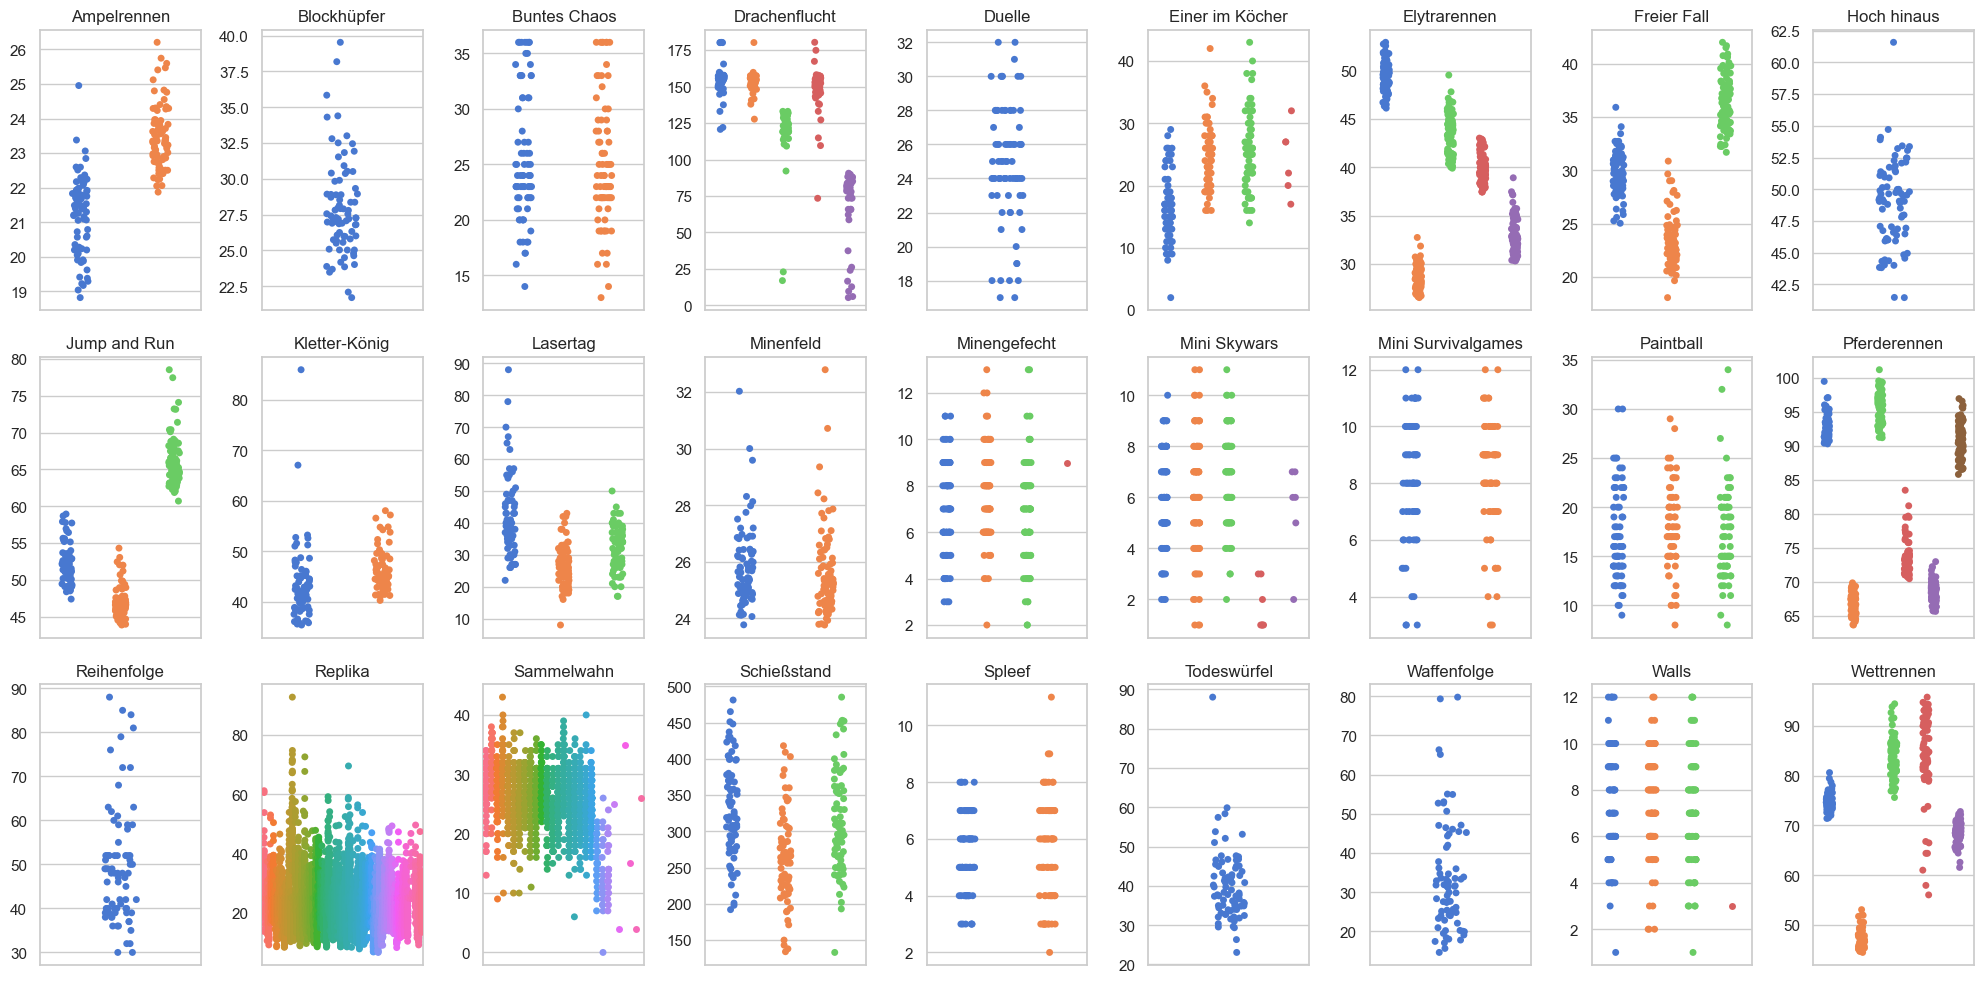

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")

# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

fig, ax = plt.subplots(ncols=9, nrows=3, figsize=[20, 10])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

# Create swarm plots for each minigame
for i, minigame in enumerate(minigames):
    data = getRecordsDataframe(minigame=minigame)
    if "Replika" in minigame: 
        data = data.drop(columns=['Sum'])
    sns.stripplot(data=data, ax=ax[i])
    ax[i].set_title(f"{minigame}")
    ax[i].set_ylabel("")

    # Angle x-labels by 45 degrees
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

    # Hide overlapping x-labels
    plt.setp(ax[i].get_xticklabels(), visible=False)
    for label in ax[i].get_xticklabels():
        label.set_visible(False)
        if label.get_text() == '':
            continue
        if ax[i].xaxis.get_major_ticks()[-1].label1.get_window_extent().bounds[2] > ax[i].get_xlim()[1]:
            label.set_visible(False)
        elif label.get_window_extent().bounds[1] < 0:
            label.set_visible(False)

# Hide any remaining empty subplots
for i in range(len(minigames), len(ax)):
    ax[i].axis('off')

plt.tight_layout()
plt.show()


/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype

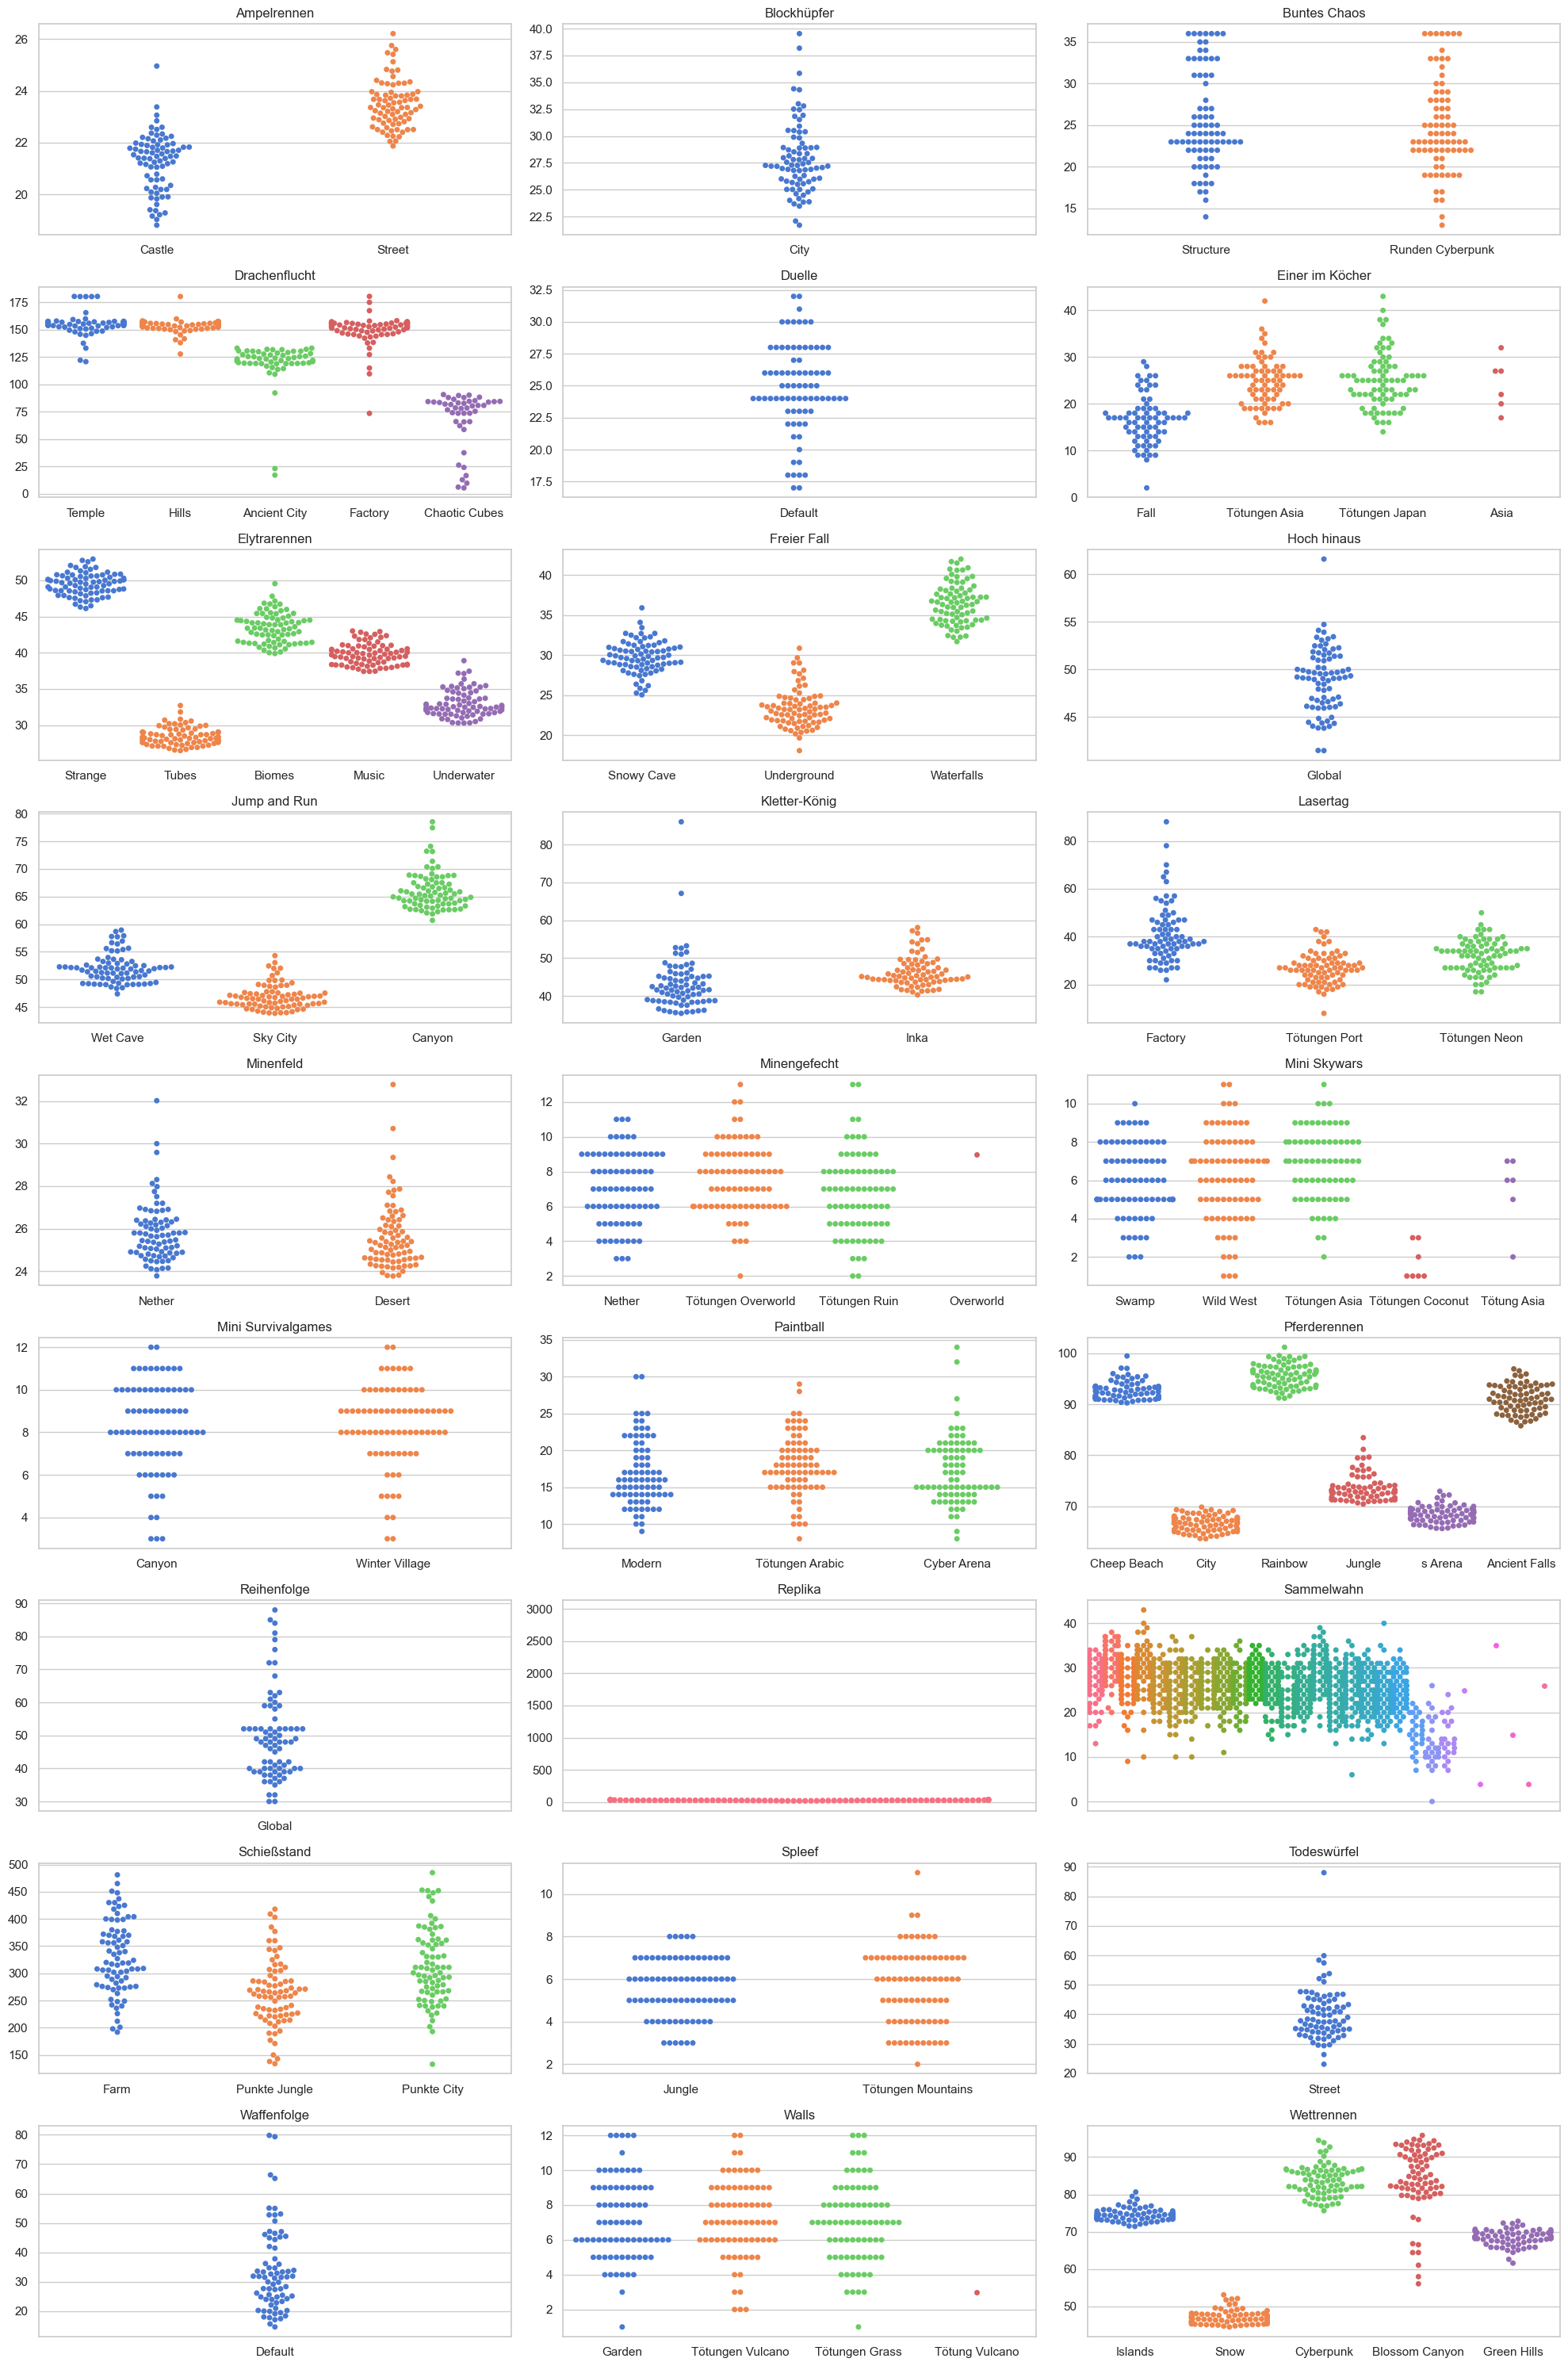

In [39]:
# List of minigames to plot
minigames = sorted((pointMiniGames + ', ' + timeMiniGames).split(', '))  # Add more minigames as needed

fig, ax = plt.subplots(9, 3, figsize=[20, 30])

# Flatten the axes array to iterate over it easily
ax = ax.flatten()

data = getRecordsDataframe(minigame="Replika")
data = data.drop(columns=["ms Cow", "ms Sonic", "Sum"])
replData = data 

# Create swarm plots for each minigame
for i, minigame in enumerate(minigames):
    if "Replika" in minigame: # drop artefact columns for Replika data 
        sns.swarmplot(data=replData, ax=ax[i])
        ax[i].set_title(f"{minigame}")
        ax[i].set_ylabel("")
        ax[i].set_xlabel("")
        ax[i].set_xticks("")
    if "Sammelwahn" in minigame: 
        sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
        ax[i].set_title(f"{minigame}")
        ax[i].set_ylabel("")
        ax[i].set_xticks("")
    else:
        sns.swarmplot(data=getRecordsDataframe(minigame=minigame), ax=ax[i])
        ax[i].set_title(f"{minigame}")
        ax[i].set_ylabel("")

# Hide any remaining empty subplots
for i in range(len(minigames), len(ax)):
    ax[i].axis('off')

plt.tight_layout()
plt.show()


/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype

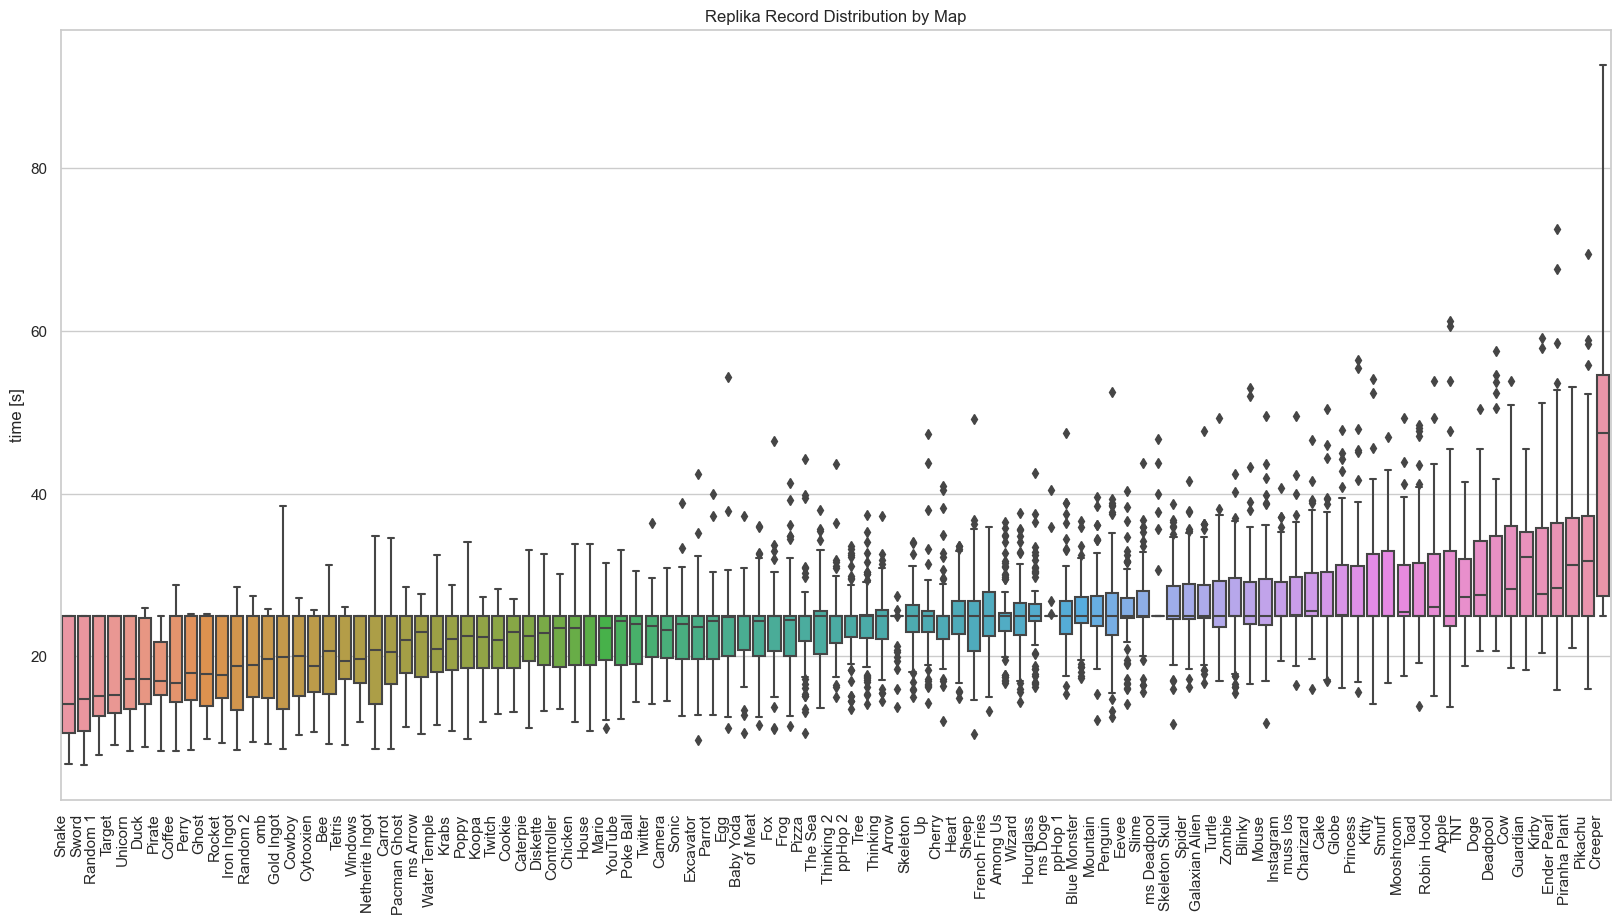

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=["ms Cow", "ms Sonic", "Sum"])
replData = data 

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype

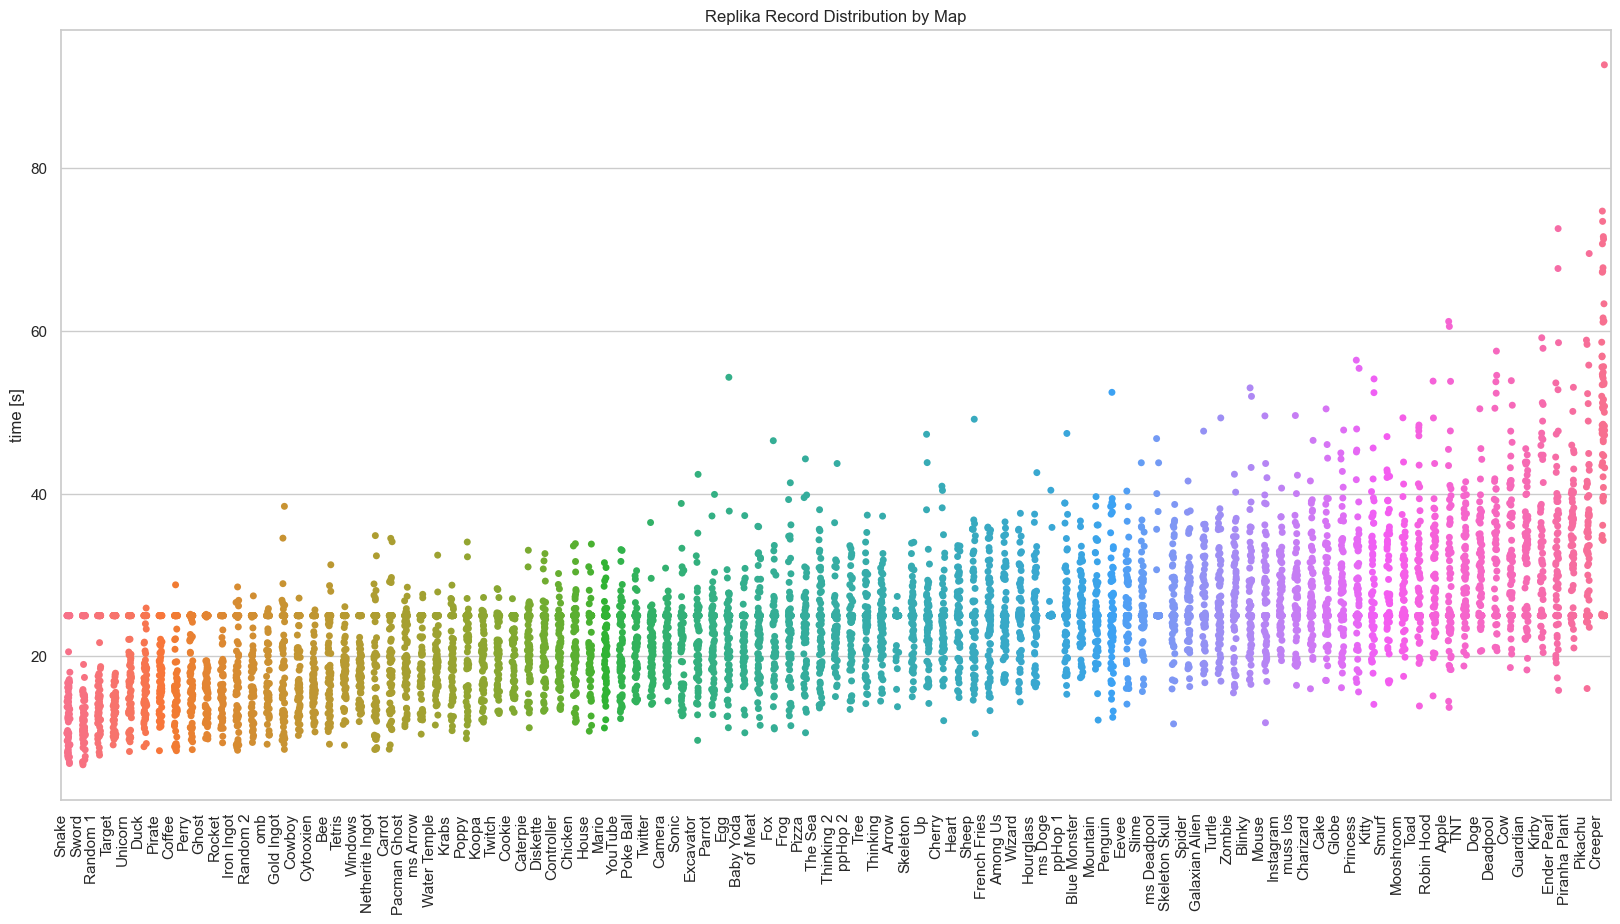

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Replika")

# Drop columns "ms Cow" and "ms Sonic"
data = data.drop(columns=["ms Cow", "ms Sonic", 'Sum'])

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.stripplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.title("Replika Record Distribution by Map")
plt.ylabel("time [s]")
plt.show()


/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/eliasmb/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype

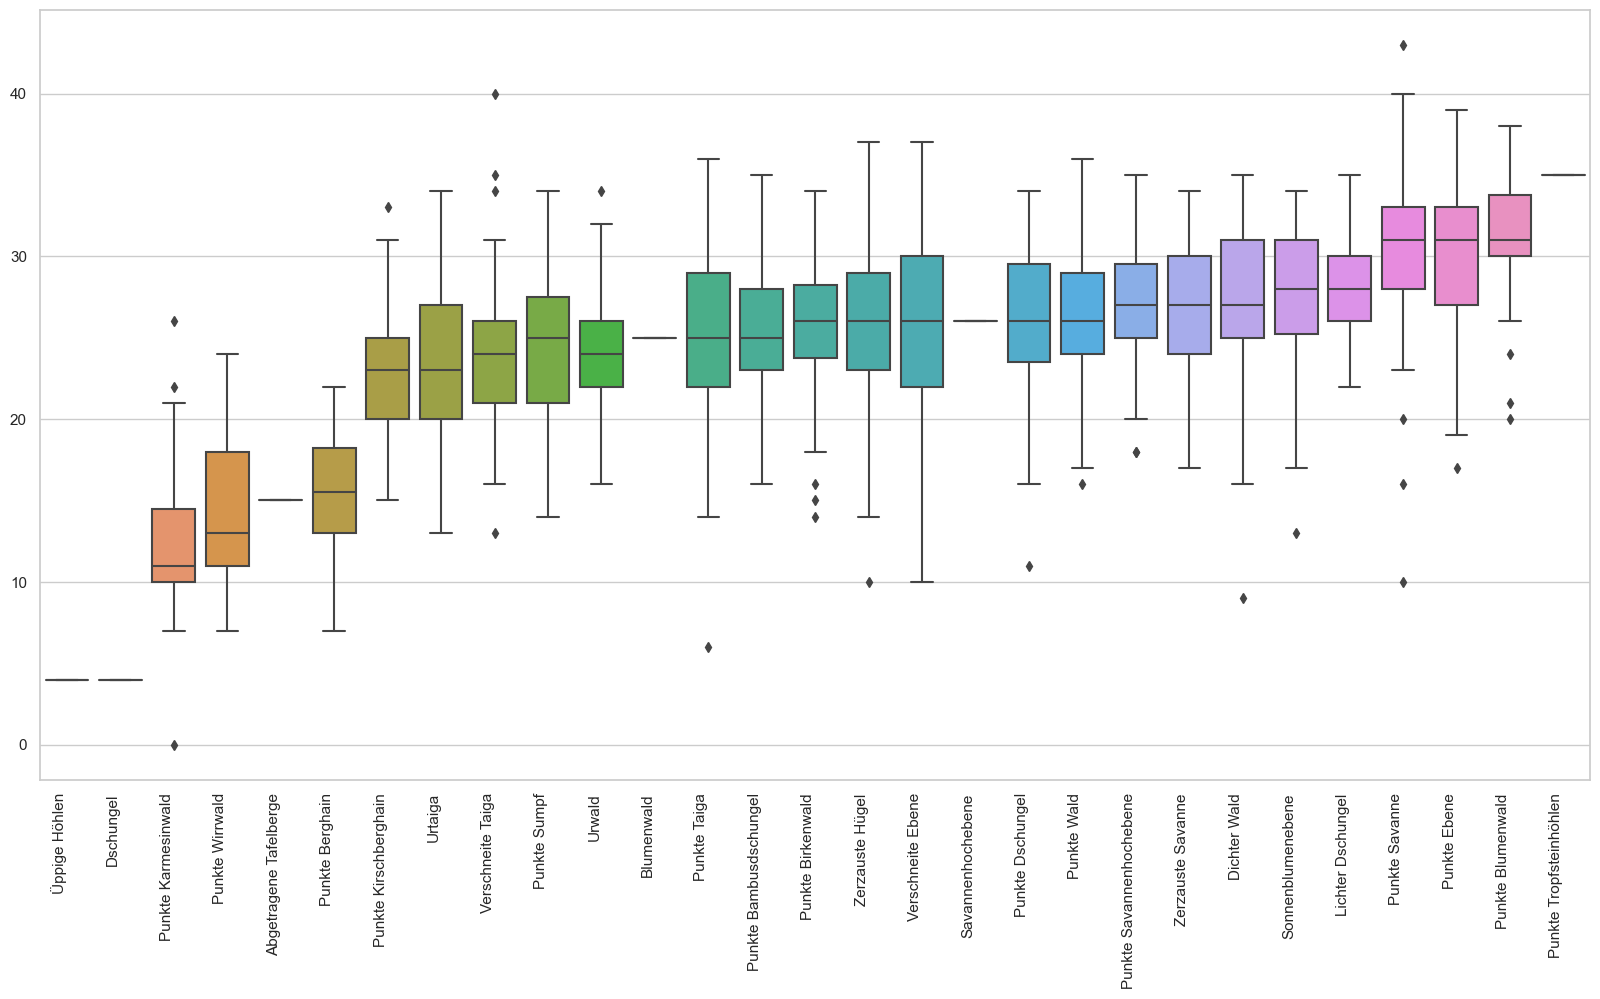

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the DataFrame for the minigame
data = getRecordsDataframe(minigame="Sammelwahn")

# Calculate mean values for each category
mean_values = data.mean()

# Sort categories based on mean values
sorted_categories = mean_values.sort_values().index

# Reindex the DataFrame using the sorted category order
data_sorted = data.reindex(columns=sorted_categories)

# Create the boxplot
fig, ax = plt.subplots(1, 1, figsize=[20, 10])
sns.boxplot(data=data_sorted)

# Rotate x-axis labels by 90 degrees and align them to the right
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()


In [43]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Replika")

# Exclude the first column (assuming it's the column you don't want to include)
df_to_html = df.iloc[:, 1:]

# Calculate the offset for centering the data points
num_columns = len(df_to_html.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df_to_html.columns):
    x_values = [i + offset] * len(df_to_html[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df_to_html[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df_to_html.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Replika Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/repl_swarm_plot.html")


In [44]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Sammelwahn")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Sammelwahn Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Points"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/sammel_swarm_plot.html")

In [45]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Pferderennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Pferderennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/pferd_swarm_plot.html")

In [46]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Wettrennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Wettrennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/wettr_swarm_plot.html")

In [47]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Drachenflucht")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Drachenflucht Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/drache_swarm_plot.html")

In [48]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Lasertag")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Lasertag Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Kills"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/laser_swarm_plot.html")

In [49]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Elytrarennen")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Elytrarennen Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/elytr_swarm_plot.html")

In [50]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Jump and Run")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="JnR Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/jump_swarm_plot.html")

In [51]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Freier Fall")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Dropper Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/fall_swarm_plot.html")

In [52]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Schießstand")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Schießstand Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Points"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/bow_swarm_plot.html")

In [53]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Paintball")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="Paintball Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Kills"),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/paint_swarm_plot.html")

In [54]:
import plotly.graph_objects as go
import plotly.io as pio

df = getRecordsDataframe(minigame="Kletter-König")

# Calculate the offset for centering the data points
num_columns = len(df.columns)
offset = 0.5

# Create a Swarm plot using Plotly
fig = go.Figure()

for i, column in enumerate(df.columns):
    x_values = [i + offset] * len(df[column])  # Adjust x-values with offset for horizontal centering
    fig.add_trace(go.Box(x=x_values,
                         y=df[column],
                         name=column,
                         boxpoints='all',
                         pointpos=-0.5,  # Adjust point position to prevent overlapping
                         marker=dict(color='rgba(0,0,0,0.5)', size=6),  # Adjust marker color and size
                         hovertext=df.index,
                         hoverinfo='text+y'))

fig.update_layout(title="KOTH Record Distribution by Map",
                  xaxis=dict(title="Map"),
                  yaxis=dict(title="Time [s]", range=[30, 65]),
                  showlegend=True,
                  font=dict(family="Arial", size=12, color="black"),  # Customize font
                  plot_bgcolor="white",  # Set background color
                  margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins for better layout
                  )

pio.show(fig)

pio.write_html(fig, "out/koth_swarm_plot.html")